In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CATEGORIES = ['COVID','non-COVID']
DATA_DIR = 'sars'
train_dir = os.path.join(DATA_DIR)

In [3]:
train_data = []
for did, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train_data.append(['{}/{}'.format(category, file), did, category])
        
train = pd.DataFrame(train_data, columns=['FILE', 'DID','CATEGORY'])
train.head()

,FILE,DID,CATEGORY
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID


In [4]:
train = train.sample(frac=1, random_state=47) 
train.index = np.arange(len(train)) 
train.head(10)

,FILE,DID,CATEGORY
0,COVID/Covid (866).png,0,COVID
1,non-COVID/Non-Covid (117).png,1,non-COVID
2,non-COVID/Non-Covid (471).png,1,non-COVID
3,COVID/Covid (855).png,0,COVID
4,non-COVID/Non-Covid (157).png,1,non-COVID
5,non-COVID/Non-Covid (1024).png,1,non-COVID
6,COVID/Covid (173).png,0,COVID
7,COVID/Covid (206).png,0,COVID
8,COVID/Covid (968).png,0,COVID
9,non-COVID/Non-Covid (464).png,1,non-COVID


In [5]:
def plot_images(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12,12))
    defect_files = train['FILE'][train['CATEGORY'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(DATA_DIR, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

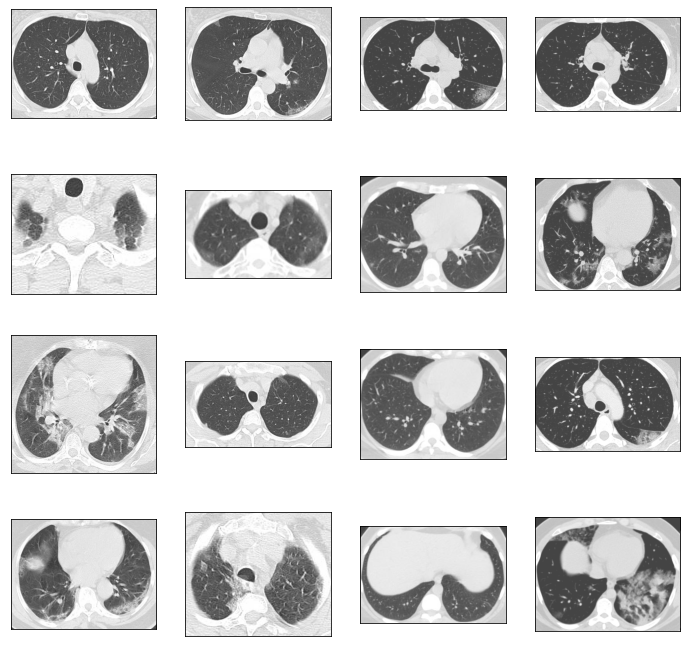

In [6]:
# Displays first n images of class from training set
plot_images('COVID', 4, 4)

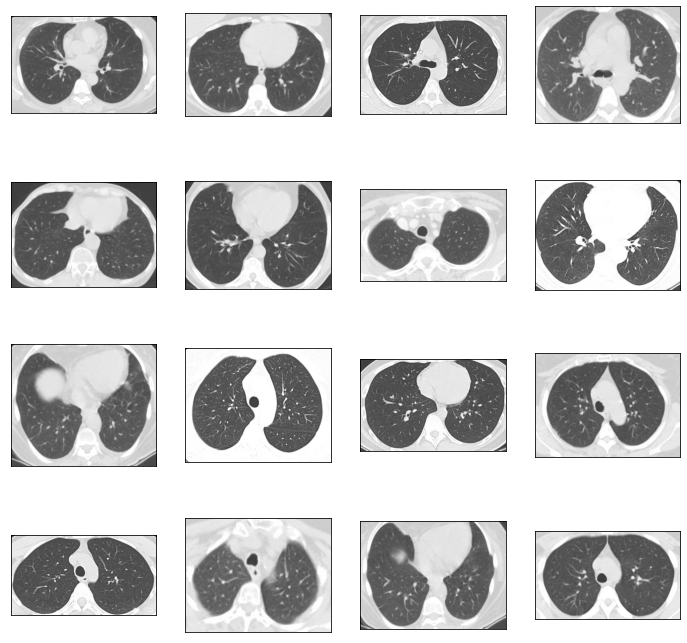

In [7]:
plot_images('non-COVID', 4, 4)

In [8]:
IMAGE_SIZE = 120

def read_image(filepath):
    return cv2.imread(os.path.join(DATA_DIR, filepath)) 

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['FILE'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        
# Normalize the data
X_train = X_train / 255.
print('Train Shape: {}'.format(X_train.shape))

2481it [00:08, 278.94it/s]


Train Shape: (2481, 120, 120, 3)


In [10]:
from keras.utils.np_utils import to_categorical

Y_train = train['DID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [11]:
from sklearn.model_selection import train_test_split

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=47)

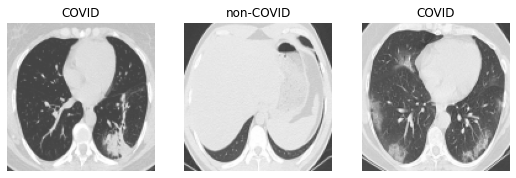

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9,9))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(CATEGORIES[np.argmax(Y_train[i])])

In [22]:
EPOCHS = 25
SIZE = 120
N_CH = 3
BATCH_SIZE = 256

In [14]:
# InceptionV3

import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,load_model
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPool2D,BatchNormalization
from keras.layers import AveragePooling2D,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import InceptionV3

def build_in():
    inception = InceptionV3(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_CH))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = inception(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
# Data Augmentation and Fitting Model

model = build_in()

annealer = ReduceLROnPlateau(monitor='val_accuracy', 
                             factor=0.5, patience=5, 
                             verbose=1, min_lr=1e-3)

checkpoint = ModelCheckpoint('InceptionV3.h5', verbose=1, save_best_only=True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 120, 120, 3)       84        
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [23]:
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/25

Epoch 1: val_loss did not improve from 0.65907
8/8 - 95s - loss: 0.6743 - accuracy: 0.6799 - val_loss: 0.6601 - val_accuracy: 0.5795 - lr: 0.0010 - 95s/epoch - 12s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.65907 to 0.64857, saving model to InceptionV3.h5
8/8 - 90s - loss: 0.6074 - accuracy: 0.7036 - val_loss: 0.6486 - val_accuracy: 0.5734 - lr: 0.0010 - 90s/epoch - 11s/step
Epoch 3/25

Epoch 3: val_loss did not improve from 0.64857
8/8 - 89s - loss: 0.6039 - accuracy: 0.7177 - val_loss: 0.6491 - val_accuracy: 0.5875 - lr: 0.0010 - 89s/epoch - 11s/step
Epoch 4/25

Epoch 4: val_loss did not improve from 0.64857
8/8 - 90s - loss: 0.5942 - accuracy: 0.7162 - val_loss: 0.6486 - val_accuracy: 0.5996 - lr: 0.0010 - 90s/epoch - 11s/step
Epoch 5/25

Epoch 5: val_loss improved from 0.64857 to 0.63878, saving model to InceptionV3.h5
8/8 - 91s - loss: 0.6222 - accuracy: 0.7374 - val_loss: 0.6388 - val_accuracy: 0.6157 - lr: 0.0010 - 91s/epoch - 11s/step
Epoch 6/25

Epoch 6: va

In [27]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 3s 198ms/step - loss: 0.5166 - accuracy: 0.7384
Final Loss: 0.5166447758674622, Final Accuracy: 0.7384305596351624


16/16 [==============================] - 3s 199ms/step


Text(0.5, 103.73999999999997, 'Predicted')

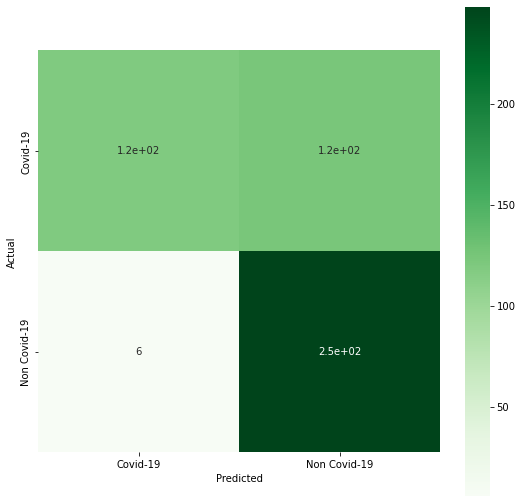

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(9, 9))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=CATEGORIES, yticklabels=CATEGORIES)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

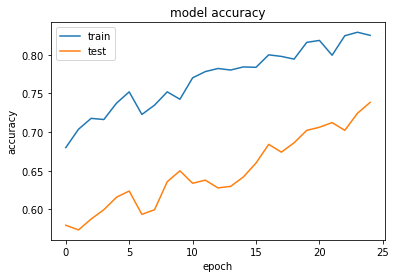

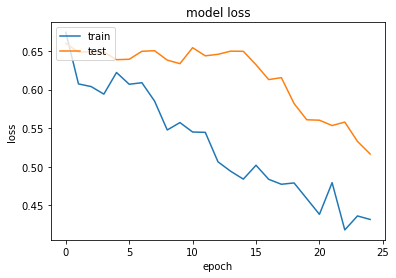

In [29]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 30ms/step
[nan nan]


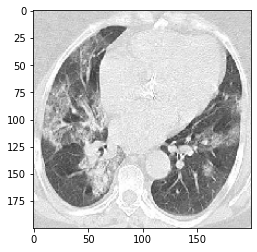

Prediction made: Covid-19


In [31]:
from skimage import io
import keras
import tensorflow as tf

img = keras.utils.load_img('sars/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img = keras.utils.load_img('sars/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
CATEGORIES = ['Covid-19','Non Covid-19']
x = tf.keras.utils.img_to_array (img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction made:',CATEGORIES[ind])